## 1.1 注意力机制
注意力机制的核心逻辑建立在 “注意力是稀缺资源” 这一基本前提之上：人类大脑在每秒接收的海量信息中，只会选择性地聚焦于一小部分关键内容，而非同等处理所有信息。

从信息处理的触发方式来看，注意力可分为两类核心类型：
- 一类是 “非自主性提示”，即由外部刺激的突出性引发的被动关注，比如视觉场景中鲜艳的红色杯子会自然吸引注意力；
- 另一类是 “自主性提示”，即由主观意图驱动的主动关注，比如刻意想要在书架上找到某本书的行为

传统网络层仅依赖固定的权重参数处理信息，完全不包含自主性提示的引导逻辑，而注意力机制的核心优势正是引入了 “自主性提示” 来主动筛选信息。

为了将上述认知逻辑转化为可计算的神经网络结构，注意力机制被抽象为 **“查询（Query）、键（Key）、值（Value）”** 三要素框架。
- 查询 Q 对应人类的自主性提示，即 “你想找什么信息”；
- 键 K 对应非自主性提示，即 “信息本身的特征标签”；
- 值 V 则是实际需要处理的信息内容。

三者的交互逻辑是：通过计算查询与键的匹配程度，生成对应的注意力权重，再基于该权重对值进行加权求和，最终实现对关键信息的选择性聚焦

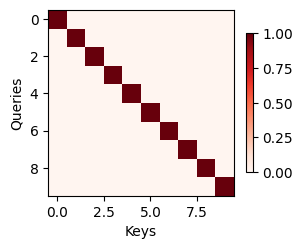

In [ ]:
import torch
import matplotlib.pyplot as plt

def show_heatmap(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示注意力权重热图"""
    # matrices形状：（行数，列数，查询数，键数）
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]

    # 创建子图
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize = figsize,
        sharex=True, sharey=True,
        squeeze=False  # 保持axes始终为2D数组
    )

    # 遍历每个矩阵绘制热图
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            matrix = matrices[i, j]  # 获取当前矩阵
            im = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            
            # 设置标签
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    
    # 添加颜色条
    fig.colorbar(im, ax=axes, shrink=0.6)
    plt.show()

# 示例：创建单位矩阵作为注意力权重（模拟“每个查询仅关注对应键”的理想场景）
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmap(
    attention_weights, 
    xlabel='Keys', 
    ylabel='Queries',
    figsize=(3, 3)
)
# 注意力权重的直观例子
# 形状说明：(batch_size, num_heads, num_queries, num_keys)
# 假设有10个键值对，10个查询
# weights = torch.eye(10)  # 对角线为1，表示每个查询只关注对应的键
# weights = weights.reshape(1, 1, 10, 10)  # 添加batch和head维度

在实际应用中，注意力权重并非手动设定的单位矩阵，而是通过模型学习得到的：

首先计算**查询（Q）** 与**键（K）** 的相似度（常用方式为 Q 与 K 的转置矩阵相乘），再通过**缩放**（除以键维度的平方根）和 softmax 函数归一化，最终得到 0-1 之间的注意力权重

$$weights = softmax\left(\frac{Q \times K^T}{\sqrt{d_k}}\right)$$

其中$d_k$为键的维度。

从张量形状来看，注意力权重通常为`(batch_size, num_heads, num_queries, num_keys)`，分别对应**批量大小**、**注意力头数**、**查询数量**和**键数量**，这一形状设计适配了批量处理和多头注意力的扩展需求。

- **全连接层**的输出由固定权重矩阵与输入的线性变换决定，公式为$output = W \times x + b$，其权重一旦训练完成便固定不变，对所有输入采用相同的处理方式；
- 而**注意力层**的核心是**动态权重**，权重由查询与键的实时交互结果决定，完整计算流程分为三步：
  - 第一步计算查询与键的相似度分数，
  - 第二步通过 softmax 函数将分数归一化为注意力权重，
  - 第三步将权重与值相乘并求和得到最终输出。

这种动态特性使得注意力机制能够根据不同的查询意图（即不同的输入）自适应地调整信息关注的重点，这也是其在自然语言处理、计算机视觉等领域表现优异的核心原因

从概念对应关系来看，**查询**作为自主性意图的载体，在神经网络中表现为模型学习到的向量；
**键**作为信息的特征标识，对应输入数据的特征表示；
**值**作为实际的信息内容，对应输入的原始数据或高阶特征；
而整个 “基于权重对值加权求和” 的过程被称为 **“注意力汇聚”**，对应人类认知中的选择性聚焦行为。

### 1.1.1 Nadaraya-Watson 核回归
Nadaraya - Watson 核回归是 Nadaraya 和 Watson 于 1964 年独立提出的一种非参数回归方法，核心是通过核函数衡量样本点间相似度并进行加权平均，来估计变量间的非线性依赖关系，后面我们会慢慢介绍。

先回过头来看回归问题的核心目标：

给定一组输入 - 输出对 $\{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$，学习一个函数 $f$，使得对于新的输入 $x$，能够准确预测其对应的输出 $y$。

In [ ]:
# 先来生成数据
import numpy as np

n_train = 50 # 训练样本数
x_train = torch.sort(torch.rand(n_train) * 5)[0] # 生成0-5范围内排序的训练输入，排序便于后续可视化

def f(x):
    return 2 * torch.sin(x) + x**0.8 # 定义真实的目标函数

y_train = f(x_train) + torch.normal(0.0, 0.5, size=x_train.shape)
x_test = torch.arange(0.0, 5.0, 0.1)  # 生成密集的测试输入，覆盖0-5区间
y_truth = f(x_test)
n_test = len(x_test)


In [7]:
def plot_predictions(y_hat, title=""):
    plt.figure(figsize=(8, 5))
    plt.scatter(x_train, y_train, alpha=0.5, label='Training data', s=20)
    plt.plot(x_test, y_truth, 'k-', label='True function', linewidth=2)
    plt.plot(x_test, y_hat, 'r-', label='Prediction', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

#### 1.1.1.1 平均汇聚
平均汇聚（Mean Aggregation）是最朴素的回归方法，其核心逻辑完全忽略输入 $x$ 的特征，直接对所有训练样本的输出 $y_i$ 取平均值作为预测结果。

$$ \hat{y}(x) = \frac{1}{n} \sum_{i=1}^{n} y_i $$

比如训练数据里有 50 个(x_i, y_i)样本，先算出这 50 个y_i的平均值（比如是 3.2）；

那么对于测试集中的任何 x（比如 x=1、x=2.5、x=4.8），预测的 y 值都固定是 3.2；

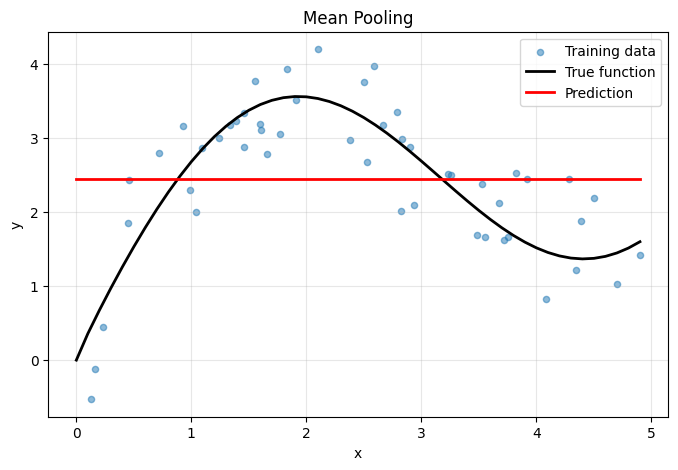

In [ ]:
# 步骤1：计算训练集所有y值的平均值
y_train_average = y_train.mean()  # 比如结果是3.2（具体值由你的随机数据决定）
# 步骤2：把这个平均值重复n_test次（n_test是测试集的数量，这里是50个）
# 因为测试集有50个x值，每个x都要对应一个预测值，且都等于这个平均值
y_hat_mean = torch.repeat_interleave(y_train_average, n_test)  # repeat_interleave 重复每个元素 n_test 次

plot_predictions(y_hat_mean, "Mean Pooling")

- 蓝色散点：训练数据（带噪声的真实函数点）；
- 黑色曲线：真实的函数f(x)=2*sin(x)+x^0.8；
- 红色曲线：平均汇聚的预测结果 ——一条水平的直线
平均汇聚的问题显而易见，它完全丢失了输入 x 与输出 y 之间的关联，无论输入 x 取何值，预测结果都是固定的均值，无法捕捉目标函数的非线性特征，仅能作为后续方法的基准参照。
#### 1.1.1.2 非参数注意力汇聚
Nadaraya-Watson（N-W）回归最初是统计学的非参数回归方法，不是为机器学习设计的，后来因为 “加权平均 + 局部关注” 的思想，被借鉴到机器学习的注意力机制中。

为了利用输入 $x$ 的特征，**Nadaraya-Watson 核回归**（Nadaraya-Watson Kernel Regression）引入了 “注意力权重” 的思想。

根据查询点 $x$ 与训练样本 $x_i$ 之间的距离，为每个训练样本的输出 $y_i$ 分配不同的权重。距离越近的样本权重越大，最终通过加权平均得到预测值：

$$ \hat{y}(x) = \sum_{i=1}^{n} [\alpha(x, x_i) \cdot y_i] $$

其中，注意力权重 $\alpha(x, x_i)$ 通常由**高斯核函数（Gaussian Kernel）**结合 Softmax 运算得到：

$$ \alpha(x, x_i) = \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^{n} \exp\left(-\frac{1}{2}(x - x_j)^2\right)} $$

或者简写为：

$$ \alpha(x, x_i) = \text{softmax}\left(-\frac{(x - x_i)^2}{2}\right) $$

这里的 Softmax 函数确保了所有权重之和为 1，从而实现了归一化。

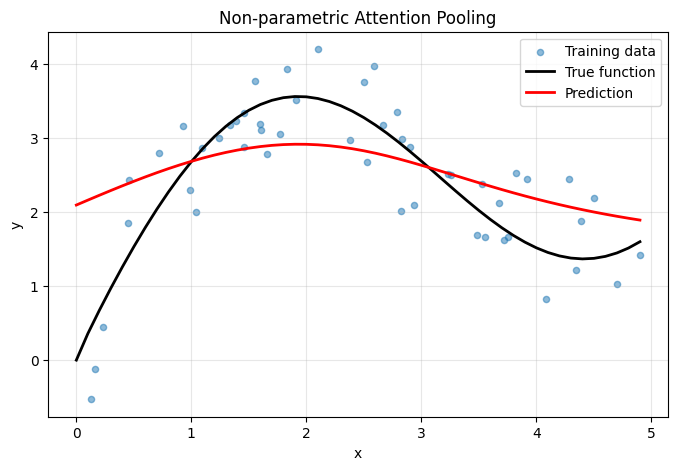

In [9]:
def n_w_nonparam(x_query, x_keys, y_values):

    x_query_expanded = x_query.reshape(-1, 1)  # 把x_test（50,）→ 变成（50, 1）：50行1列（每个测试点占一行）
    x_keys_expanded = x_keys.reshape(1, -1)    # 把x_train（50,）→ 变成（1, 50）：1行50列（每个训练点占一列） 

    # 计算注意力权重（高斯核）
    distances = x_query_expanded - x_keys_expanded  # 触发广播机制
    # (50,1)的张量会被复制成(50,50)（每行都是同一个测试点）；
    # (1,50)的张量会被复制成(50,50)（每列都是同一个训练点）；
    # 相减后得到的distances形状是(50,50)，其中distances[i,j]就是第 i 个测试点和第 j 个训练点的距离。
    attention_weights = torch.nn.functional.softmax(-distances**2 / 2, dim=1)
    # 距离远的值越小（负数），而dim=1表示沿着列维度求和归一化，对每个测试点的 50 个权重归一化
    # 把上面的 “距离得分” 转换成权重，保证每个测试点对应的 50 个训练点权重加起来等于 1（这样加权平均才有意义）

    # 加权平均
    y_hat = attention_weights @ y_values  # （50, 100） @（100,） =（50,），表示矩阵点积
    return y_hat, attention_weights

y_hat_nw, attention_weights_nw = n_w_nonparam(x_test, x_train, y_train)
plot_predictions(y_hat_nw, "Non-parametric Attention Pooling")


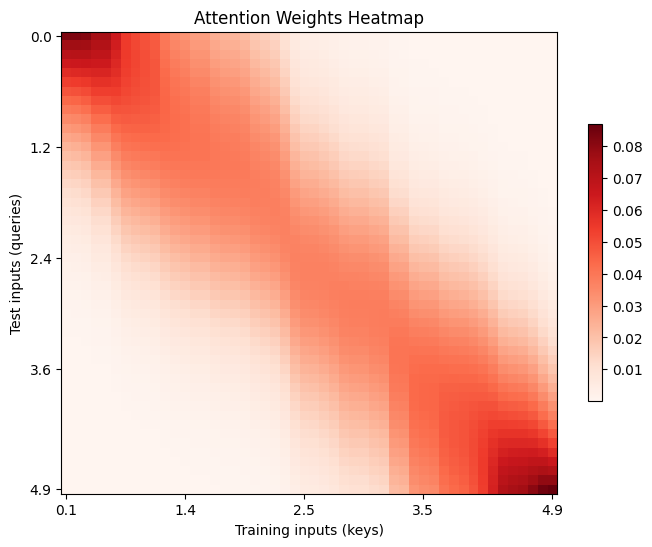

In [11]:
# 可视化注意力权重
def plot_attention_heatmap(attention_weights, x_keys, x_queries):
    """绘制注意力权重热图"""
    plt.figure(figsize=(8, 6))
    im = plt.imshow(attention_weights.numpy(), cmap='Reds', aspect='auto')
    plt.colorbar(im, shrink=0.6)
    plt.xlabel('Training inputs (keys)')
    plt.ylabel('Test inputs (queries)')
    plt.title('Attention Weights Heatmap')
    
    # 设置刻度（示例）
    n_ticks = 5
    key_ticks = np.linspace(0, len(x_keys)-1, n_ticks).astype(int)
    query_ticks = np.linspace(0, len(x_queries)-1, n_ticks).astype(int)
    
    plt.xticks(key_ticks, [f"{x_keys[i]:.1f}" for i in key_ticks])
    plt.yticks(query_ticks, [f"{x_queries[i]:.1f}" for i in query_ticks])
    plt.show()

plot_attention_heatmap(attention_weights_nw, x_train, x_test)

我们再来回顾一下最基本的回归问题：
你有一堆“已知答案”的样本 $(x_1,y_1), (x_2,y_2)...$（比如“温度10℃，销量50件”），想学会一个规律，当给你一个新的$x$（比如“温度15℃”），能准确算出对应的$y$（销量）。

$f(x) = 2\sin(x) + x^{0.8}$ 就是这个“隐藏的规律”，我们的目标就是让模型尽可能逼近这个规律。

| 变量名       | 通俗含义                                                                 | 角色定位                |
|--------------|--------------------------------------------------------------------------|-------------------------|
| `x_train`    | 训练用的输入（比如“已知温度”），0-5之间50个排序好的数                     | 注意力中的 **Key（键）** |
| `y_train`    | `x_train` 对应的输出（带噪声的“已知销量”），是$f(x_{\text{train}})$加了高斯噪声    | 注意力中的 **Value（值）** |
| `x_test`     | 要预测的新输入（比如“新温度”），0-5之间每隔0.1取一个数（共50个）          | 注意力中的 **Query（查询）** |
| `y_truth`    | `x_test` 对应的“标准答案”，直接代入真实函数$f(x)$算出                     | 用来对比预测准不准的参照 |
| `y_hat`      | 各种方法算出的`x_test`的预测值（hat是“帽子”，代表“估计/预测”）            | 最终的预测结果          |

注意力机制的本质是“**根据查询（Query）找最匹配的键（Key），再用键对应的值（Value）做预测**”，在这个核回归例子里，对应关系是：
- **Query（查询）** = `x_test`：你“想问的问题”（比如“$x=2.5$对应的$y$是多少？”）；
- **Key（键）** = `x_train`：你“已知答案的问题索引”（比如“我知道$x=2.3/2.6$对应的$y$是多少”）；
- **Value（值）** = `y_train`：你“已知答案的问题对应的答案”（Key对应的结果）。

## 极简示例（无噪声，方便理解）
假设 `x_train = [1,2,3]`（Key），`y_train = [2,4,6]`（Value，真实规律是$y=2x$）；
现在Query是 `x_test=2.1`，想预测$\hat{y}$：

### 1. 平均汇聚（无注意力）
- 逻辑：不管Query是什么，直接把所有Value取平均，相当于“所有Key都一样重要”。
- 计算：$\hat{y} = (2+4+6)/3 = 4$
  → 哪怕Query是1.1/2.1/3.1，预测值都是4，完全忽略$x$的特征。

### 2. Nadaraya-Watson 核回归（有注意力）
- 逻辑：根据Query和Key的距离，给不同Key分配“注意力权重”（距离越近，权重越大），再加权平均Value。
- 计算过程：
  1. 算距离：$2.1-1=1.1$，$2.1-2=0.1$，$2.1-3=0.9$ → Key=2离Query=2.1最近；
  2. 转权重（softmax归一化）：Key=2的权重≈0.65（最高），Key=1≈0.15，Key=3≈0.2；
  3. 加权平均：$\hat{y}= 0.15\times2 + 0.65\times4 + 0.2\times6 = 4.1$
  → 接近真实值$4.2$（$2\times2.1$），这就是“注意力”的作用——**只关注和Query最像的Key**。

注意力热图画的是50×50的权重矩阵：
- 横轴（x 轴）：训练点 x_train 的数值，从上到下对应 x 值从 0.0 → 4.9（也就是你要预测的输入）；
- 纵轴（y 轴）：测试点 x_test 的数值，从左到右对应 x 值从 0.1 → 4.9（也就是你已知的训练输入）；

**热图中位置 $(i, j)$ 的颜色/数值**：表示 “第 $i$ 个测试点（$x_{\text{test}}[i]$）对第 $j$ 个训练点（$x_{\text{train}}[j]$）的注意力权重 $\alpha(x_{\text{test}}[i], x_{\text{train}}[j])$”。

**举例**：热图中 y 轴索引 10（对应 $x_{\text{test}}[10]=1.0$）、x 轴索引 8（对应 $x_{\text{train}}[8]\approx0.9$）的位置颜色最红 $\rightarrow$ 说明 $x_{\text{test}}=1.0$ 这个查询点，对 $x_{\text{train}}\approx0.9$ 这个训练点的权重最高。

预测值 = 查询点对应的权重矩阵行 × 训练 y 值，距离近的训练点权重更高，最终让预测曲线贴合真实函数。

非参数 Nadaraya-Watson 核回归的核心特点是：权重完全由数据本身的距离关系决定，无需训练任何参数，高斯核函数保证了 “距离越近、权重越大” 的注意力特性，预测结果能够较好地贴合真实函数的趋势。

通过注意力权重热图，我们可以清晰看到，“对角线” 附近颜色最红（比如测试点 x=2，对训练点 x≈2 的权重最高），每个测试查询点（y 轴）会对与其数值接近的训练键点（x 轴）分配更高的权重，这正是注意力机制 “选择性关注” 的直观体现

#### 1.1.3 带参数注意力汇聚
非参数核回归虽然效果优于平均汇聚，但权重的计算方式固定（高斯核），缺乏对数据的自适应能力。为此，我们引入可学习参数 $w$ 对距离进行缩放，改进后的权重公式为：

$$ \alpha(x, x_i) = \text{softmax}\left(-\frac{[w \cdot (x - x_i)]^2}{2}\right) $$

其中 $w$ 由模型通过训练学习得到，能够自适应调整距离对权重的影响程度。

Epoch 20, Loss: 0.3395, w: 4.4398
Epoch 40, Loss: 0.3202, w: 5.8112
Epoch 60, Loss: 0.3129, w: 6.6340
Epoch 80, Loss: 0.3108, w: 7.0722
Epoch 100, Loss: 0.3102, w: 7.3075


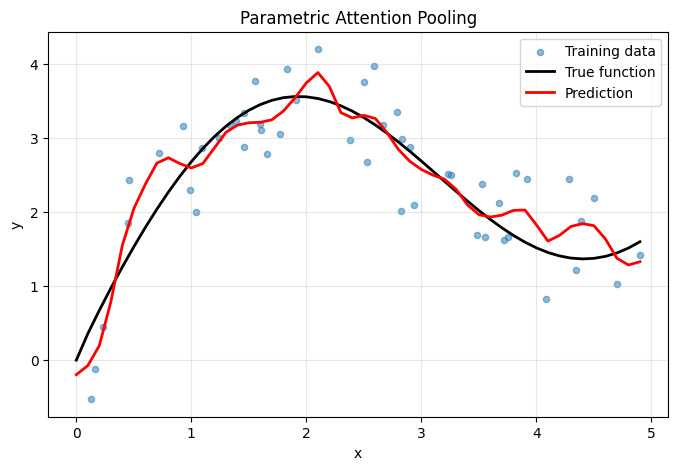

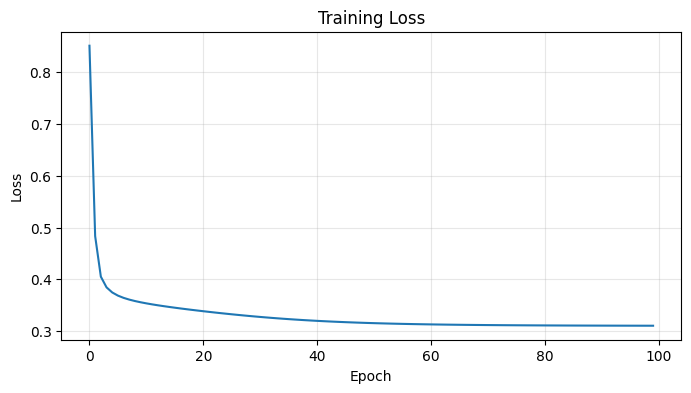

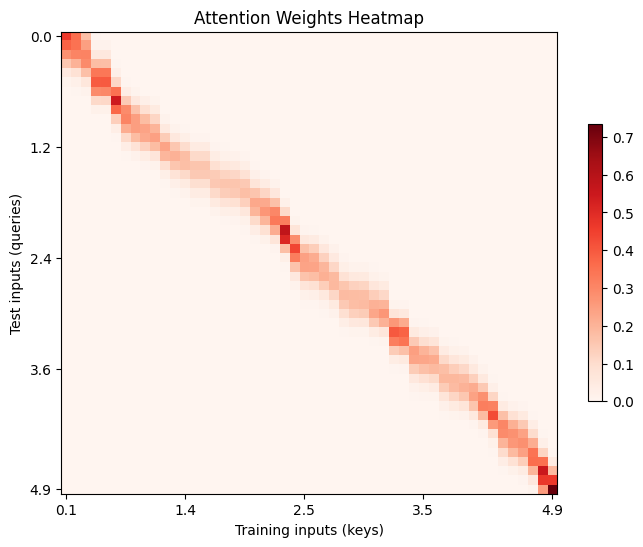

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class param_attn(nn.Module):
    def __init__(self):
        super().__init__()
        # 核心：定义可学习参数w（nn.Parameter标记为可优化参数，初始值随机正态分布）
        self.w = torch.nn.Parameter(torch.randn(1))  
        # 只有用这个包装的张量，才会被优化器（如 SGD）追踪梯度、参与反向传播更新
        # 如果直接用self.w = torch.randn(1)，w 不会被训练

    def forward(self, queries, keys, values):
        # 步骤1：维度扩展（和非参数版本完全一致）
        # queries(x_test)：(m,) → (m,1)；keys(x_train)：(n,) → (1,n)
        queries_expanded = queries.reshape(-1, 1)
        keys_expanded = keys.reshape(1, -1)
        
        # 步骤2：核心改进——用可学习参数w缩放距离
        scaled_distances = self.w * (queries_expanded - keys_expanded)

        # 步骤3：计算注意力权重（逻辑同非参数，只是距离被w缩放）
        attention_weights = F.softmax(-scaled_distances**2/2, dim=1)
        self.attention_weights = attention_weights  # 保存权重用于后续可视化

        # 步骤4：加权求和（替代矩阵乘法的等价实现）
        values_expanded = values.reshape(1, -1)  # (n,) → (1,n)
        # 把values扩展为(m,n)，和attention_weights形状匹配（每行都是相同的values）
        values_weighted = values_expanded.expand(queries.size(0), -1)
        # einsum：'mn,mn->m' → 对每个m（查询点），计算n个元素的逐元素相乘后求和
        y_hat = torch.einsum('mn,mn->m', attention_weights, values_weighted)
        return y_hat

def train_param(model, x_train, y_train, epochs=100, lr=0.1):
    # 步骤1：定义优化器（SGD）和损失函数（均方误差MSE，回归任务的核心损失）
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # 只优化model中的可学习参数（即w）
    loss_fn = torch.nn.MSELoss()

    # 步骤2：关键操作——为每个训练样本构建「排除自身」的键值对（避免过拟合）
    n = len(x_train)
    x_keys = []
    y_values = []
    for i in range(n):
        mask = torch.ones(n, dtype=torch.bool)  # 初始化全True的掩码
        mask[i] = False  # 把第i个样本的掩码设为False（排除自身）
        x_keys.append(x_train[mask])  # 第i个样本的keys = 所有训练样本除了自己
        y_values.append(y_train[mask])  # 第i个样本的values = 所有训练样本除了自己
    
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for i in range(n):
            # 步骤3：单样本训练（每次用第i个训练样本做query，排除自身的样本做keys/values）
            optimizer.zero_grad()  # 清空梯度（避免梯度累积）
            query = x_train[i].unsqueeze(0)  # (1,) → 匹配模型输入的维度要求
            y_pred = model(query, x_keys[i], y_values[i])  # 预测第i个样本的y值
            loss = loss_fn(y_pred, y_train[i].unsqueeze(0))  # 计算预测值和真实值的MSE损失
            # unsqueeze(0)：把标量（如 x_train [i]）转为形状 (1,) 的张量，匹配模型forward函数对输入维度的要求（模型期望 queries 是一维张量）
            loss.backward()  # 反向传播：计算w的梯度
            optimizer.step()  # 更新w：w = w - lr * 梯度
            total_loss += loss.item()  # 累加损失
        
        avg_loss = total_loss / n  # 计算本轮平均损失
        losses.append(avg_loss)
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, w: {model.w.item():.4f}")
    return losses

model = param_attn()
losses = train_param(model, x_train, y_train)

# 用训练好的模型预测x_test的y值（注意detach()：剥离梯度，才能转numpy可视化）
y_hat_param = model(x_test, x_train, y_train)
plot_predictions(y_hat_param.detach(), "Parametric Attention Pooling")

# 可视化损失曲线（验证模型是否收敛）
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

# 可视化注意力权重（detach()同理）
plot_attention_heatmap(model.attention_weights.detach(), x_train, x_test)

- 如果数据噪声大，$w$ 可能 $< 1$ → 距离被缩小，相同实际距离下，$-(w \cdot d)^2/2$ 更大 → 权重分布更分散，注意力权重更分散，避免过度拟合噪声；
- 如果数据规律明显，$w$ 可能 $> 1$ → 距离被放大，相同实际距离下，$-(w \cdot d)^2/2$ 更小 → 权重更集中在极近的样本，注意力权重更聚焦，贴合真实函数；
这里$w$最终为7左右，更贴合训练数据。

#### 1.1.4 批量矩阵乘法优化
上述实现中，逐样本计算的方式效率较低，尤其当数据量较大时，循环操作会显著增加计算耗时。为此，我们可以利用批量矩阵乘法（torch.bmm）或爱因斯坦求和（torch.einsum）实现批量计算，提升运行效率

> BTW torch.einsum 等价于非参数版本的 attention_weights @ y_values，只是写法不同
> 'mn,mn->m'：m = 查询点数量，n = 训练点数量；
> 计算逻辑：对每个查询点 i（第 i 行），计算attention_weights[i,j] * values_weighted[i,j]（j 从 1 到 n），然后求和得到 y_hat [i]；
> 效果和矩阵乘法attention_weights @ values完全一致，只是更直观体现 “逐元素相乘再求和” 的加权逻辑。

In [ ]:
class batchParam_attn(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(1))  
    
    def forward(self, q, k, v):
        """
        批量版本的带参数注意力汇聚
        参数：
            queries: (batch_size, num_queries)
            keys: (batch_size, num_keys)
            values: (batch_size, num_keys)
        返回：
            y_hat: (batch_size, num_queries)
        """
        q_expanded = q.unsqueeze(2)  # (batch_size, num_queries, 1)
        k_expanded = k.unsqueeze(1)  # (batch_size, 1, num_keys)
        v_expanded = v.unsqueeze(1)  # (batch_size, 1, num_keys)

        distances = self.w * (q_expanded - k_expanded)
        attention_weights = F.softmax(-distances**2/2, dim=2) # dim=2表示在keys维度上进行softmax

        # 批量矩阵乘法：(B, Q, K) @ (B, K, 1) = (B, Q, 1)，高效实现加权求和
        y_hat = torch.bmm(attention_weights, v_expanded)
        # bmm = Batch Matrix Multiplication（批量矩阵乘法）
        return y_hat.squeeze(2)     # 去除最后一维，得到(B, Q)的预测结果



批量实现的核心是利用张量的维度扩展和广播机制，将逐样本的循环操作转化为矩阵运算，大幅降低时间复杂度，这也是实际工程中处理大规模数据的常用优化方式。

| 方法 | 核心公式 | 核心特点 | 优点 | 缺点 |
|------|----------|----------|------|------|
| 平均汇聚 | $\hat{y} = \text{mean}(y_i)$ | 无注意力机制，完全忽略输入特征 | 实现简单、计算成本极低 | 无法捕捉输入输出的关联，预测效果差 |
| 非参数注意力汇聚 | $\hat{y} = \sum[\text{softmax}(-(x-x_i)^2/2)·y_i]$ | 高斯核权重，权重由数据距离决定 | 无需训练、预测平滑、一致性好 | 计算复杂度$O(n^2)$、无自适应学习能力 |
| 带参数注意力汇聚 | $\hat{y} = \sum[\text{softmax}(-[w·(x-x_i)]^2/2)·y_i]$ | 可学习缩放参数，权重自适应调整 | 灵活适配数据特性、预测精度更高 | 可能过拟合小数据集、预测曲线不平滑 |

- **注意力机制的本质**：本质是“加权平均”，区别于普通平均的核心在于“权重的动态性”——权重由查询（新输入）与键（训练输入）的相似度决定，而非固定均分。
- **核函数的作用**：核函数（如高斯核）是将“距离”转化为“相似度”的桥梁，高斯核的特性保证了“距离越近，相似度越高，权重越大”，这是注意力“选择性关注”的基础。
- **参数化的意义**：引入可学习参数并非改变注意力的核心逻辑，而是让模型自主学习“如何衡量距离的重要性”，提升对不同数据集的适配能力。
- **与高阶注意力的关联**：Nadaraya-Watson核回归是注意力机制的最简形式，自注意力、多头注意力等复杂注意力机制，本质上都是“查询-键-值”框架下加权平均思想的扩展。
- 非参数模型无需训练，但受限于核函数的固定形式，在数据分布复杂时可能无法充分捕捉特征；
- 带参数模型在训练时需注意过拟合问题，尤其是小数据集场景，可通过调整学习率、限制训练轮数等方式缓解；
- 两种注意力汇聚的计算复杂度均为$O(n^2)$，适用于小规模数据，大规模场景需结合采样、稀疏化等策略优化。

- **总结**
1. 注意力汇聚的核心是**动态加权平均**，权重由查询与键的相似度（距离）决定，区别于平均汇聚的固定均分权重；
2. 非参数/带参数注意力汇聚的核心差异在于是否引入可学习的距离缩放参数$w$，参数化可提升数据适配性但需防范过拟合；
3. 批量矩阵运算可优化注意力汇聚的计算效率，而$O(n^2)$的复杂度决定其更适合小规模数据，大规模场景需额外优化。

## 1.2 注意力评分函数
高斯核指数部分可以视为注意力评分函数（attention scoring function）， 简称评分函数（scoring function）。
![计算注意力汇聚的输出为值的加权和](/img/pytorch/attn_rate.png)

无论采用何种评分函数，注意力机制的核心流程始终保持一致：先通过评分函数计算查询与所有键的相似度分数，再通过 Softmax 将分数归一化为注意力权重，最后使用权重对值进行加权求和得到输出


In [ ]:
# 注意力汇聚的一般形式
def attention_pooling(query, keys, values, scoring_function):
    """
    通用注意力汇聚函数，适配任意评分函数
    参数：
        query: (batch_size, query_dim) 或 (batch_size, num_queries, query_dim)
        keys: (batch_size, num_keys, key_dim)
        values: (batch_size, num_keys, value_dim)
        scoring_function: 注意力评分函数，输入(query, keys)返回相似度分数
    返回：
        output: (batch_size, num_queries, value_dim)，加权求和结果
        weights: (batch_size, num_queries, num_keys)，注意力权重
    """
    # 1. 计算查询与所有键的相似度分数
    scores = scoring_function(query, keys)  # 形状为(batch_size, num_queries, num_keys)
    
    # 2. Softmax归一化，dim=-1确保每个查询的权重之和为1
    weights = torch.softmax(scores, dim=-1)
    
    # 3. 批量矩阵乘法实现加权求和：权重 @ 值
    output = torch.bmm(weights, values)
    return output, weights

### 1.2.1 遮蔽 Softmax
在 NLP 等场景中，批量数据是变长序列（比如两句话：["我 / 爱 / 编程", "我 / 爱 / 中国 / 北京"]），为了统一批次维度，会对短序列填充无效值（Padding，比如第一句填充为 ["我 / 爱 / 编程 /[PAD]"]）。

如果直接用普通 Softmax，注意力权重会分配到[PAD]位置（无效键），导致加权求和时包含无效信息。掩蔽 Softmax 的作用是：把填充位置的分数设为负无穷，让 Softmax 后这些位置的权重趋近于 0，仅有效位置参与权重分配。

In [ ]:
import math
def masked_softmax(X, valid_lens):
    """
    掩蔽Softmax实现，处理变长序列的注意力权重计算
    参数：
        X: 3D张量 (batch_size, num_queries, num_keys) 或 2D张量 (batch_size, num_keys)
        valid_lens: 1D张量(batch_size,)或2D张量(batch_size, num_queries)，表示每个序列/查询的有效长度
    返回：
        output: 与X形状相同的张量，填充位置权重为0
    """
    # 无有效长度限制时，直接返回普通Softmax
    if valid_lens is None:
        return F.softmax(X, dim=-1)

    # 统一有效长度维度为（batch_size * num_q,）
    shape = X.shape           # 保存原始形状，方便最后恢复
    if valid_lens.dim() == 1:
        # 情况1：1D有效长度，每个样本的所有查询共享有效长度
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else: 
        # 2D有效长度，展开为一维
        valid_lens = valid_lens.reshape(-1)
    

### 1.2.2 加性注意力